In [1]:
import pickle
from pathlib import Path
import face_recognition
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from catboost import CatBoostClassifier

In [2]:
with open('config/actress_actors.json', 'r') as fp:
    dict_act = json.load(fp)

In [3]:
all_actors = dict_act['women'] + dict_act['men']
len(all_actors)

135

In [4]:
dict_labels = {key: num for num, key in enumerate(all_actors)}
dict_labels

{'Alicia Vikander': 0,
 'Amy Adams': 1,
 'Andie MacDowell': 2,
 'Angelina Jolie': 3,
 'Anne Hathaway': 4,
 'Cameron Diaz': 5,
 'Carey Mulligan': 6,
 'Cate Blanchett': 7,
 'Catherine Zeta-Jones': 8,
 'Charlize Theron': 9,
 'Claire Forlani': 10,
 'Demi Moore': 11,
 'Drew Barrymore': 12,
 'Elizabeth Taylor': 13,
 'Emma Stone': 14,
 'Eva Mendes': 15,
 'Frances McDormand': 16,
 'Gwyneth Paltrow': 17,
 'Halle Berry': 18,
 'Hilary Swank': 19,
 'Jennifer Aniston': 20,
 'Jessica Biel': 21,
 'Jessica Chastain': 22,
 'Jodie Foster': 23,
 'Julia Roberts': 24,
 'Julianne Moore': 25,
 'Juliette Binoche': 26,
 'Kate Winslet': 27,
 'Keira Knightley': 28,
 'Kim Basinger': 29,
 'Kirsten Dunst': 30,
 'Kristin Scott Thomas': 31,
 "Lupita Nyong'o": 32,
 'Maggie Gyllenhaal': 33,
 'Marion Cotillard': 34,
 'Meg Ryan': 35,
 'Megan Fox': 36,
 'Melanie Laurent': 37,
 'Meryl Streep': 38,
 'Michelle Pfeiffer': 39,
 'Milla Jovovich': 40,
 'Naomi Watts': 41,
 'Natalie Portman': 42,
 'Natasha Henstridge': 43,
 'Nicol

In [65]:
with open('config/actors_labels.json','w') as f:
    json.dump(dict_labels, f)

In [6]:
face_embedings = []
face_labels = []

for sex in tqdm(dict_act.keys()):
    for person in tqdm(dict_act[sex]):
        person_embedings = []
        person_labels = []

        files = list(Path(f'dataset/{sex}/{person}').glob('*.jpg'))

        if len(files) < 2:
            print(f'[WARNING] - Менее 2 изображений в датасете: {person}. Не включаем в датасет')
        else:
            for person_img in files:
                # Считыаем изображение
                face = face_recognition.load_image_file(person_img)
                # Получаем координаты лица
                face_locations = face_recognition.face_locations(face)

                # проверка что лицо на изображение одно и количество глаз больше 2
    #             if len(face_locations) == 1 and count_eyes(face, face_locations[0]) >= 2:
                if len(face_locations) == 1:
                    face_encoding = face_recognition.face_encodings(face, face_locations)
                    person_embedings.append(face_encoding)
                    person_labels.append(dict_labels[person])

        if len(person_labels) > 1:
            face_embedings.extend(person_embedings)
            face_labels.extend(person_labels)
        else:
            print(f"[WARNING] - Исключаем {person} из-за нехватки корректных изображения в датасете")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

In [9]:
embedings = np.concatenate(face_embedings)
embedings.shape

(2149, 128)

In [10]:
with open('encodings/embedings_all.pkl','wb') as f:
    pickle.dump(embedings, f)
    
with open('encodings/labels_all.pkl','wb') as f:
    pickle.dump(face_labels, f)

In [5]:
with open('encodings/embedings_all.pkl','rb') as f:
    embedings_all = pickle.load(f)
    
with open('encodings/labels_all.pkl','rb') as f:
    target_all = pickle.load(f)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    embedings_all, target_all, test_size=0.3, stratify=target_all, random_state=42)

In [7]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [8]:
f1 = f1_score(y_test, clf.predict(X_test), average='micro')
print(f'F1 score = {f1}')

F1 score = 0.8651162790697674


In [27]:
model_cat = CatBoostClassifier(
                                iterations = 500,
                                early_stopping_rounds=30,
                               ).fit(X_train, y_train)

f1 = f1_score(y_test, model_cat.predict(X_test), average='micro')
print(f'F1 score = {f1}')

Learning rate set to 0.145122
0:	learn: 4.7823435	total: 5.37s	remaining: 44m 41s
1:	learn: 4.6712583	total: 10.5s	remaining: 43m 46s
2:	learn: 4.5639239	total: 15.6s	remaining: 43m 5s
3:	learn: 4.4601315	total: 20.7s	remaining: 42m 47s
4:	learn: 4.3426698	total: 26s	remaining: 42m 49s
5:	learn: 4.2178653	total: 31.1s	remaining: 42m 43s
6:	learn: 4.1190884	total: 36.3s	remaining: 42m 39s
7:	learn: 4.0027637	total: 41.4s	remaining: 42m 28s
8:	learn: 3.8837940	total: 46.7s	remaining: 42m 26s
9:	learn: 3.7732778	total: 51.9s	remaining: 42m 22s
10:	learn: 3.6631632	total: 57s	remaining: 42m 15s
11:	learn: 3.5541135	total: 1m 2s	remaining: 42m 10s
12:	learn: 3.4560695	total: 1m 7s	remaining: 42m 2s
13:	learn: 3.3633023	total: 1m 12s	remaining: 41m 54s
14:	learn: 3.2713753	total: 1m 17s	remaining: 41m 52s
15:	learn: 3.1769701	total: 1m 22s	remaining: 41m 49s
16:	learn: 3.0773436	total: 1m 28s	remaining: 41m 42s
17:	learn: 2.9833060	total: 1m 33s	remaining: 41m 37s
18:	learn: 2.8882306	total:

152:	learn: 0.1968174	total: 13m 34s	remaining: 30m 46s
153:	learn: 0.1956584	total: 13m 39s	remaining: 30m 42s
154:	learn: 0.1936297	total: 13m 45s	remaining: 30m 36s
155:	learn: 0.1920763	total: 13m 50s	remaining: 30m 30s
156:	learn: 0.1903416	total: 13m 55s	remaining: 30m 24s
157:	learn: 0.1882057	total: 14m	remaining: 30m 19s
158:	learn: 0.1857818	total: 14m 5s	remaining: 30m 13s
159:	learn: 0.1844468	total: 14m 10s	remaining: 30m 7s
160:	learn: 0.1823333	total: 14m 15s	remaining: 30m 1s
161:	learn: 0.1801588	total: 14m 20s	remaining: 29m 56s
162:	learn: 0.1787565	total: 14m 25s	remaining: 29m 50s
163:	learn: 0.1775809	total: 14m 31s	remaining: 29m 44s
164:	learn: 0.1764978	total: 14m 36s	remaining: 29m 39s
165:	learn: 0.1749133	total: 14m 41s	remaining: 29m 33s
166:	learn: 0.1729271	total: 14m 46s	remaining: 29m 27s
167:	learn: 0.1711345	total: 14m 51s	remaining: 29m 22s
168:	learn: 0.1695343	total: 14m 56s	remaining: 29m 16s
169:	learn: 0.1680630	total: 15m 1s	remaining: 29m 10s


300:	learn: 0.0734326	total: 26m 20s	remaining: 17m 24s
301:	learn: 0.0730866	total: 26m 25s	remaining: 17m 19s
302:	learn: 0.0727915	total: 26m 30s	remaining: 17m 14s
303:	learn: 0.0723785	total: 26m 35s	remaining: 17m 8s
304:	learn: 0.0720034	total: 26m 40s	remaining: 17m 3s
305:	learn: 0.0714905	total: 26m 46s	remaining: 16m 58s
306:	learn: 0.0711670	total: 26m 51s	remaining: 16m 52s
307:	learn: 0.0707203	total: 26m 56s	remaining: 16m 47s
308:	learn: 0.0703334	total: 27m 1s	remaining: 16m 42s
309:	learn: 0.0700911	total: 27m 6s	remaining: 16m 36s
310:	learn: 0.0697122	total: 27m 11s	remaining: 16m 31s
311:	learn: 0.0694104	total: 27m 16s	remaining: 16m 26s
312:	learn: 0.0690269	total: 27m 22s	remaining: 16m 21s
313:	learn: 0.0687293	total: 27m 27s	remaining: 16m 15s
314:	learn: 0.0685437	total: 27m 32s	remaining: 16m 10s
315:	learn: 0.0681606	total: 27m 37s	remaining: 16m 5s
316:	learn: 0.0679888	total: 27m 42s	remaining: 15m 59s
317:	learn: 0.0677188	total: 27m 47s	remaining: 15m 5

449:	learn: 0.0416536	total: 39m 24s	remaining: 4m 22s
450:	learn: 0.0415184	total: 39m 30s	remaining: 4m 17s
451:	learn: 0.0413634	total: 39m 35s	remaining: 4m 12s
452:	learn: 0.0412589	total: 39m 40s	remaining: 4m 7s
453:	learn: 0.0411541	total: 39m 46s	remaining: 4m 1s
454:	learn: 0.0410788	total: 39m 51s	remaining: 3m 56s
455:	learn: 0.0409461	total: 39m 56s	remaining: 3m 51s
456:	learn: 0.0408131	total: 40m 1s	remaining: 3m 46s
457:	learn: 0.0406662	total: 40m 7s	remaining: 3m 40s
458:	learn: 0.0405257	total: 40m 13s	remaining: 3m 35s
459:	learn: 0.0404541	total: 40m 18s	remaining: 3m 30s
460:	learn: 0.0403675	total: 40m 23s	remaining: 3m 25s
461:	learn: 0.0402905	total: 40m 28s	remaining: 3m 19s
462:	learn: 0.0401512	total: 40m 33s	remaining: 3m 14s
463:	learn: 0.0401023	total: 40m 38s	remaining: 3m 9s
464:	learn: 0.0399500	total: 40m 43s	remaining: 3m 3s
465:	learn: 0.0398599	total: 40m 48s	remaining: 2m 58s
466:	learn: 0.0397774	total: 40m 54s	remaining: 2m 53s
467:	learn: 0.03

In [37]:
with open('model/catboost_all.pkl','wb') as f:
    pickle.dump(model_cat, f)

In [5]:
with open('model/catboost_all.pkl','rb') as f:
    model = pickle.load(f)

In [6]:
def resize_image(SIZE, image):
    # получим его размер
    size = image.size

    # получим коэффициент, на который нужно уменьшить/увеличить
    # изображение по одной из сторон до SIZE
    coef = SIZE / size[0]
    # изменяем размер изображения
    resized_image = image.resize(
        (int(size[0] * coef), int(size[1] * coef)))
    res_image = resized_image.convert('RGB')
    return res_image

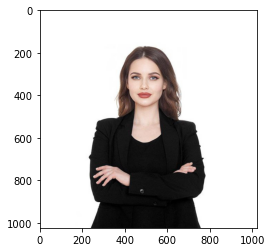

In [7]:
# Масштабируем изображение для четкости
SIZE = 1024
test_path = 'test_photo.jpg'
test_resized = 'my_test_res.jpg'

image = Image.open(test_path)
res_image = resize_image(SIZE, image)
res_image.save(test_resized)

plt.imshow(res_image);

In [8]:
pil_image = np.asarray(res_image)

In [9]:
def predict_actress(path, model, dict_labels):
    face = face_recognition.load_image_file(path)
    face_locations = face_recognition.face_locations(face)
    
    if len(face_locations) == 1:
        # Преобразуем фото с лицом в вектор, получаем embeding 
        face_enc = face_recognition.face_encodings(face, face_locations)[0]
        
        # Предикт actress/actor
        predict = model.predict([face_enc])
        predict_labels = list(filter(lambda x: x[1] == predict, dict_labels.items()))[0][0]
        
        preict_proba = model.predict_proba([face_enc])
        
        # Топ 5 актеров (индексы актеров)
        top_5 = preict_proba[0].argsort()[::-1][:5]
        
        top_5_actors_name = get_key(dict_labels, top_5)
        top_5_prob = preict_proba[0][top_5].tolist()
        return top_5_actors_name, top_5_prob
        
    else:
        print('Проблемы с поиском лица. Должно быть одно лицо и 2 глаза')
        

In [11]:
def get_key(dict_labels, values):
    inverse_dict = {v:k for k, v in dict_labels.items()}
    return [inverse_dict[key] for key in values]

In [12]:
predict_name, preict_proba = predict_actress(test_resized, model, dict_labels)
predict_name

['Nina Dobrev',
 'Scarlett Johansson',
 'Marion Cotillard',
 'Emma Stone',
 'Kate Winslet']

In [13]:
preict_proba

[0.13207537076356296,
 0.06990754102383763,
 0.05690641114635687,
 0.04034550607942505,
 0.03282905530844655]

In [14]:
s = sum(preict_proba)
new = list(map(lambda x: round(x / s * 100, 1), preict_proba))
new

[39.8, 21.1, 17.1, 12.1, 9.9]

In [15]:
# таблица со скорами
data = {'act':get_key(dict_labels, model.classes_),
        'score': preict_proba[0]
       }

df = pd.DataFrame(data)
df.sort_values(by='score')[::-1]

,act,score
134,Willem Dafoe,0.132075
49,Reese Witherspoon,0.132075
35,Meg Ryan,0.132075
36,Megan Fox,0.132075
37,Melanie Laurent,0.132075
...,...,...
95,James McAvoy,0.132075
96,Jamie Foxx,0.132075
97,Jeff Goldblum,0.132075
98,Jeff Bridges,0.132075


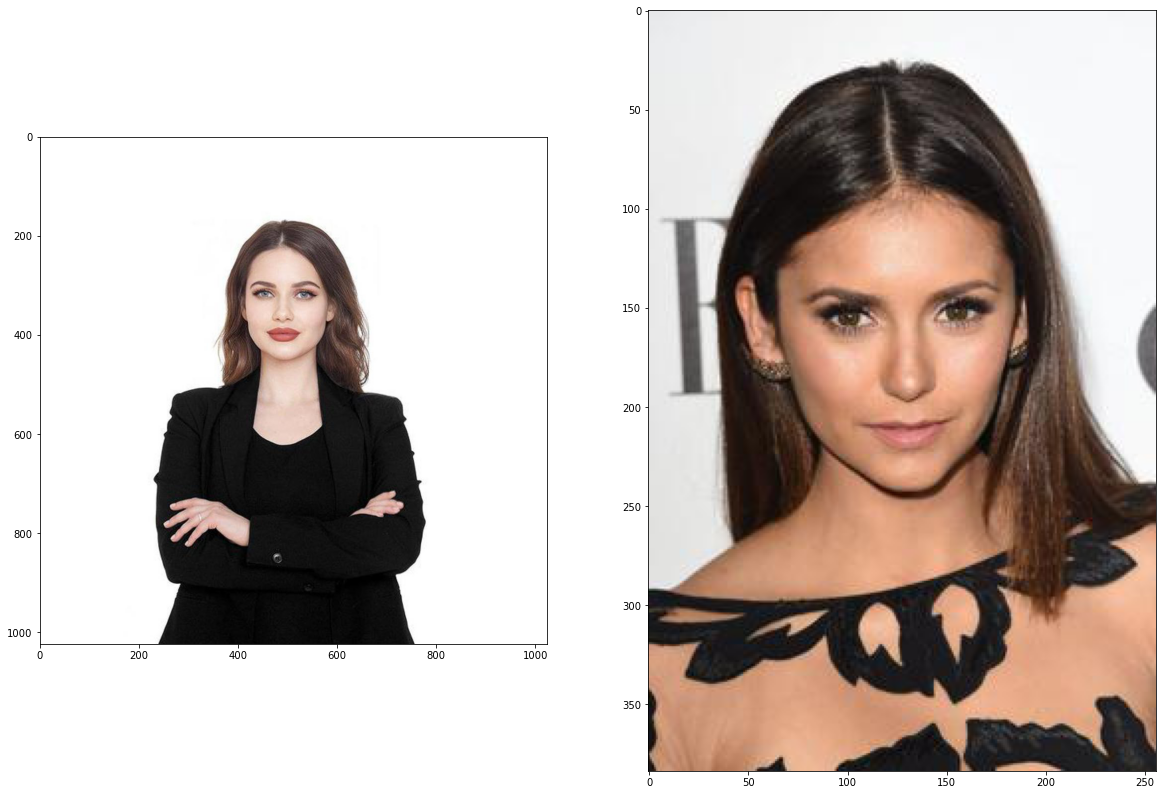

In [17]:
num_image = 10

image1 = face_recognition.load_image_file(test_resized)
image2 = face_recognition.load_image_file(f"dataset/women/{predict_name[0]}/Image_{num_image}.jpg")

fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(image1)
ax[1].imshow(image2);